### Preliminary cell to start the notebook

In [1]:
# libraries
import os
import sys
import platform
print(sys.version)

in_colab = 'google.colab' in sys.modules
strong_pc = platform.system() == 'Linux'

if in_colab:
    if not os.getcwd().split('/')[-1].split('_')[-1]=='2023':
        from google.colab import drive
        drive.mount('/content/drive')
        os.chdir(r'/content/drive/MyDrive/Human_Data_Analytics_Project_2023')

    if not 'tensorflow_io' in sys.modules:
        print('Installing tensorflow-IO')
        !pip install tensorflow-io
    if not 'keras' in sys.modules:
        print('Installing keras')
        !pip install keras==2.10.0
    if not 'scikeras' in sys.modules:
        print('Installing scikeras')
        !pip install scikeras[tensorflow]
    if not 'keras-tuner' in sys.modules:
        print('installing keras tuner')
        !pip install keras-tuner
        !pip install numba==0.57.0

main_dir = os.getcwd()
if main_dir not in sys.path:
    print('Adding the folder for the modules')
    sys.path.append(main_dir)

#BASE LIBRARIES
import numpy as np
import pandas as pd
import h5py
import shutil
import time
import random
import subprocess
import itertools
import warnings
import pickle
import json

#PLOT LIBRARIES
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
#import plotly.express as px

#AUDIO LIBRARIES
import librosa
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft,ifft,fftfreq, fftshift
from scipy.signal import stft,spectrogram,periodogram
#from pydub import AudioSegment

#MACHINE LEARNING LIBRARIES
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, LeaveOneOut, train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.utils import check_random_state
from scikeras.wrappers import KerasClassifier
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.utils import plot_model as tf_plot
if in_colab:
    import tensorflow_io as tfio
print("TensorFlow version:", tf.__version__)
# show keras version
import keras
print(f'keras version = {keras.__version__}')
#import keras_tune as kt
from keras import layers
import keras_tuner as kt
from tensorflow import keras
from tensorflow.keras.regularizers import L1L2
# kernel_regularizer=regularizers.L1L2(l1=1e-5, l2=1e-4) # we may use this in some layers...

#RANDOM SETTINGS
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
check_random_state(seed)

#EVALUATION LIBRAIRES
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn.metrics import precision_recall_fscore_support, auc

#OUR PERSONAL FUNCTIONS
import importlib
from Preprocessing.data_loader import download_dataset,load_metadata
from Preprocessing.exploration_plots import one_random_audio, plot_clip_overview, Spectral_Analysis
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC
from Visualization.model_plot import confusion_matrix,listen_to_wrong_audio

importlib.reload(importlib.import_module('Preprocessing.data_loader'))
importlib.reload(importlib.import_module('Models.basic_ml'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Preprocessing.data_loader import load_metadata
#df_ESC10, df_ESC50 = load_metadata(main_dir,heads = False, ESC_US = False, statistics=False)

from Preprocessing.data_loader import load_metadata
from Models.basic_ml import basic_ML_experiments, basic_ML_experiments_gridsearch, build_dataset, extract_flatten_MFCC

importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))

from Models.ann_utils import *
from Models.ann_utils import MFCCWithDeltaLayer,OutputCutterLayer
from Visualization.model_plot import plot_history, confusion_matrix, listen_to_wrong_audio, visualize_the_weights

ESC10_path = os.path.join(main_dir,'Data', 'ESC-10-depth')
samplerate = 44100

3.11.4 (main, Jul  5 2023, 08:54:11) [Clang 14.0.6 ]


/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/tensorflow_io-0.33.0-py3.11-macosx-11.1-arm64.egg/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/tensorflow_io-0.33.0-py3.11-macosx-11.1-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ["[Errno 2] The file to load file system plugin from does not exist.: '/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/tensorflow_io-0.33.0-py3.11-macosx-11.1-arm64.egg/tensorflow_io/python/ops/libtensorflow_io_plugins.so'"]
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/Users/leonardo/anaconda3/envs/DSEnv3/lib/python3.11/site-packages/tensorflow_io-0.33.0-py3.11-macosx-11.1-arm64.egg/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open fil

TensorFlow version: 2.12.0
keras version = 2.12.0


# 3 UNSUPERVISED LEARNING: AUTOENCODERS

In [17]:
import importlib
importlib.reload(importlib.import_module('Models.ann_utils'))
importlib.reload(importlib.import_module('Visualization.model_plot'))
importlib.reload(importlib.import_module('Preprocessing.data_loader'))
from Models.ann_utils import *
from Preprocessing.data_loader import reshape_US
from Visualization.model_plot import *

## 3.2 Autoencoder on preprocessed audio MFCC - Convolutional and flatten code

As we have seen before the MEL preprocessing is always beaten by one of the other two. For this reason we are going to avoid this type of computations and we will train the autoencoder to reconstruct the MFCC or the STFT only.

### Create the dataset

In [3]:
preprocessing = 'MFCC'
AE_name = 'AE_Conv_prep_flatten_'+preprocessing
train, val, test, INPUT_DIM = create_US_dataset(
        preprocessing=preprocessing,
        folder_number=1,
        main_dir = main_dir,
)

Creating the dataset from folder 01


In [4]:
folder_path = 'Saved_Models'  # Replace this with the actual folder path
file_names = [ AE_name+'_count.txt']

for name in file_names:
    file_path = os.path.join(main_dir, folder_path, name)
    with open(file_path, 'w') as f:
        f.write('0')
    print(f"Created {name} with content '0' in folder {folder_path}")


Created AE_Conv_prep_flatten_MFCC_count.txt with content '0' in folder Saved_Models


To interpret the mean squared error the we are going to optimize in our training we need to compute some mse between our images and some random images or between couple of images in our training set.

In [5]:
mse = tf.keras.losses.MeanSquaredError()

# Extract the first batch from the training set: x is a tuple of arrays of dim (128,220500)
for x, y in train.take(1):
    #compute the mse between the first batch and a batch of random images with the same shape
    random_images_1 = tf.random.uniform(shape=x.shape, minval = -1, maxval = 1,dtype=tf.float32)
    random_images_2 = np.random.uniform(-1, 1, size = x.shape)
    print(f'Mean MSE between an audio preprocessed and a random image (tf) : {mse(x, random_images_1):.5f}')
    print(f'Mean MSE between an audio preprocessed and a random image (np): {mse(x, random_images_2):.5f}')
    print(f'Mean MSE between two random images (tf-np): {mse(random_images_1, random_images_2):.5f}')

Mean MSE between an audio preprocessed and a random image (tf) : 0.33833
Mean MSE between an audio preprocessed and a random image (np): 0.33878
Mean MSE between two random images (tf-np): 0.66618


### Preparation to use Keras-Tuner

Now we define a function to build a generic convolutional autoencoder. We'll give this function to a keras tuner.

In [6]:
#General function to build an autoencoder
#CONVOLUTIONAL AUTOENCODER WITH VECTORIAL CODE
code_size = 32
n_layers = 2
n_units = 32

# the real build function for general autoencoder (keras code)
def build_autoencoder(img_shape = INPUT_DIM,
                      code_size = code_size,
                      activation = 'tanh',
                      padding = 'valid',
                      n_layers = n_layers, #max number of layers is 3
                      n_units = n_units,
                      kernel_size = (3,3),
                      strides = (2,2),
                      max_pooling = (2,2),
                      regularizer = 1e-4,
                      batch_norm = True,
                      drop_out = 0.0,
                      learning_rate = 1e-3,
                      loss = tf.keras.losses.MeanSquaredError(),
                      metrics = ['mse'],
                      AE_name = AE_name
 ):
    lr = learning_rate
    # encoder
    encoder = tf.keras.Sequential(name='Encoder')
    encoder.add(tf.keras.Input(img_shape))
    for i in range(n_layers):
        encoder.add(layers.Conv2D(n_units * (i+1), kernel_size,strides = strides, activation = activation, padding=padding))
        encoder.add(layers.MaxPool2D(max_pooling, padding='same'))
        if batch_norm:
            encoder.add(layers.BatchNormalization())
        if drop_out > 0:
            encoder.add(layers.Dropout(drop_out))

    # flatten layer to get the code
    my_shape = encoder.layers[-1].output_shape
    encoder.add(layers.Flatten())
    encoder.add(layers.Dense(code_size,activation = activation, activity_regularizer=keras.regularizers.l1(regularizer)))

    # decoder
    decoder = tf.keras.Sequential(name='Decoder')
    decoder.add(tf.keras.Input(code_size))
    decoder.add(layers.Dense(np.prod(my_shape[1:]), activation=activation))
    decoder.add(layers.Reshape(my_shape[1:]))

    # transpose convolutions
    for i in range(n_layers):
        filters = n_units * (n_layers-i) if i<n_layers-1 else 1
        decoder.add(layers.Conv2DTranspose(filters , kernel_size, strides=strides, activation=activation, padding=padding))
        decoder.add(layers.UpSampling2D(size=max_pooling))
        if batch_norm:
            decoder.add(layers.BatchNormalization())

    #final reshape
    decoder.add(tf.keras.layers.Resizing(height = INPUT_DIM[0], width = INPUT_DIM[1], interpolation="bilinear", crop_to_aspect_ratio=False))

    # build the autoencoder with keras.Model
    inp = tf.keras.Input(shape = INPUT_DIM)
    code = encoder(inp)
    reconstruction = decoder(code)
    autoencoder = tf.keras.Model(inputs=inp, outputs=reconstruction, name = AE_name)

    # compile the autoencoder
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr) if sys.platform == 'darwin' or in_colab else tf.keras.optimizers.Adam(learning_rate = lr)
    loss = loss
    metrics = metrics

    autoencoder.compile(optimizer=optimizer,
                loss=loss,
                metrics=metrics)

    #print the number of trainable parameters
    print(f'Model built with { sum(tf.keras.backend.count_params(p) for p in autoencoder.trainable_variables)} trainable params')

    return autoencoder


In [7]:
verbose = 0
#test the build_autoencoder function
autoencoder = build_autoencoder(n_layers = 3)
if verbose > 1:
    autoencoder.summary(line_length=100)
    autoencoder.layers[1].summary(line_length=100)
    autoencoder.layers[2].summary(line_length=100)


Model built with 226403 trainable params


In [8]:
# function to build the model using different hyperparameters (keras tuner code)
def build_model(hp,test=False):

    #define hyperparameters
    if test: #if test is true you run the tuner only on a reduced hyperparameter space
        print('Running a test smaller grid search')
        n_units = 32
        n_layers = hp.Choice(name = 'n_layers', values =  [2,3])
        kernel_size = 3
        strides = 2
        max_pooling = 2
        regularizer = hp.Choice(name = 'regularizer', values = [1e-4,0.0])
        padding = 'same'
        code_size = 32
        activation = 'tanh'
        drop_out = hp.Choice(name = 'drop_out', values = [0.25,0.0])
        batch_norm = True
        lr_max, lr_min = 1e-3, 1e-3
        hp_lr = hp.Float('learning_rate', min_value=lr_min, max_value=lr_max, sampling='log')
    else:
        n_units = hp.Choice(name = 'n_units', values =  [4,8,16,32,64,128], default = 32)
        n_layers = hp.Int(name = 'n_layers', min_value = 1, max_value = 3, step=1, sampling='linear', default = 2)
        kernel_size = hp.Choice(name = 'kernel_size', values = [3,5,7], default = 3)
        strides = hp.Choice(name = 'strides', values = [2,3], default = 2)
        max_pooling = hp.Choice(name = 'max_pooling' , values = [2,3], default = 2)
        regularizer = hp.Choice(name = 'regularizer', values = [0.0,1e-2,1e-3,1e-4,1e-5], default = 1e-4)
        padding = hp.Choice(name = 'padding', values = ['same','valid'], default = 'valid')
        code_size = hp.Choice(name = 'code_size', values = [32,64,128], default = 32)
        activation = hp.Choice(name = 'activation', values = ['relu','elu','tanh'], default = 'tanh')
        drop_out = hp.Choice(name = 'drop_out', values = [0.0, 0.25, 0.5], default = 0.0)
        batch_norm = hp.Choice(name = 'batch_norm', values = [True, False], default = True)
        lr_min, lr_max =1e-4, 1e-1
        learning_rate= hp.Choice('learning_rate', values = [1e-4, 1e-3, 5*1e-3, 1e-2,5*1e-2,1e-1], default = 1e-3)


    model = build_autoencoder(code_size = code_size,
                              activation = activation,
                              padding = padding,
                              n_layers = n_layers,
                              n_units = n_units,
                              kernel_size = (kernel_size,kernel_size),
                              strides = (strides,strides),
                              max_pooling = (max_pooling, max_pooling),
                              regularizer = regularizer,
                              batch_norm = batch_norm,
                              drop_out = drop_out,
                              learning_rate= learning_rate)

    return model


In [9]:
#test the build_model function
build_model(kt.HyperParameters()).summary()

Model built with 189795 trainable params
Model: "AE_Conv_prep_flatten_MFCC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                84768     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        105349    
                                                                 
Total params: 190,117
Trainable params: 189,795
Non-trainable params: 322
_________________________________________________________________


### Implement the grid search hyperparamter-wise

In [10]:
# dictionary with the default values of the hyperparams to be update each time
default_values = {
    'n_layers': 2,
    'n_units': 32,
    'kernel_size': 3,
    'strides':2,
    'max_pooling':2,
    'regularizer':0.0,
    'padding':'valid',
    'code_size':32,
    'activation':'tanh',
    'drop_out':0.0,
    'batch_norm':True,
    'learning_rate':1e-3
}

key_list = list(default_values.keys())

#define the general variables for our tuner
hpo_methods = ['RandomSearch', 'BayesianOptimization','Hyperband']
problematic_combination = []
max_model_size = 10**6
max_trials = 10
dir_name = AE_name
verbose=0

if strong_pc:
    train_small = train
    val_small = val
else:
    small_size_dataset = 40
    train_val_small = train.unbatch().take(small_size_dataset)
    train_small = train_val_small.skip(10).batch(25)
    val_small = train_val_small.take(10).batch(25)

# define a list to collect all the best scores
best_score_dict ={
    'RandomSearch': [],
    'BayesianOptimization': [],
    'Hyperband': []
}

#to be consistent with this type of grd search we should pass each hp more than one time...
for hpo_method in hpo_methods:
    random.shuffle(key_list)
    for hyper_params in key_list:
        print(f'Searching for the best value for {hyper_params}')

        #define an hp set with all fix but one
        hp = kt.HyperParameters()

        for fixed_param in default_values.keys():
            if fixed_param != hyper_params:
                hp.Fixed(name = fixed_param, value = default_values[fixed_param])

        if verbose>1:
            display(hp.space)

        try:
            #create a tuner for the params not fixed
            tuner = build_tuner(build_model = build_model,
                                hpo_method = hpo_method,
                                max_model_size = max_model_size,
                                max_trials = max_trials,
                                dir_name = dir_name,
                                overwrite = True,
                                objective = kt.Objective('val_mse', direction='min'),
                                hp=hp,
                                not_fixed_param = hyper_params,
                                tune_new_entries=True
                                )

            if verbose>2:
                display(tuner.search_space_summary(extended = True))

            #fit the tuner
            epochs = 50
            patience = 10
            metrics = ['mse']
            callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_'+metrics[0],
                                                        verbose=verbose,
                                                        patience=patience)]

            tuner.search(train_small, validation_data = val_small,
                                callbacks=callbacks,
                                epochs=epochs,
                                verbose=int(verbose>0),
                        )

            #retrive the best value for the free hp
            best_value = tuner.get_best_hyperparameters()[0].values[hyper_params]

            #retrive the best score reached
            best_score = tuner.get_best_models(num_models=1)[0].evaluate(val, return_dict = True)['mse']

            print(f'The best value for {hyper_params} is {best_value}, the best score is {best_score}')
            best_score_dict[hpo_method].append(best_score)

            #update the default dict of values
            default_values[hyper_params] = best_value

            #save the updated dictionary
            file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
            with open(file_path, 'wb') as file:
                pickle.dump(default_values, file)

            #delete the folder just created by the run
            shutil.rmtree(os.path.join(main_dir,dir_name, hpo_method+'_'+hyper_params))

        except:
            problematic_combination.append(('search_for'+hyper_params, default_values))

    with open(file_path, 'rb') as file:
        best_params = pickle.load(file)

    display(best_params)

#save the best_score_dict
file_path = os.path.join(main_dir, dir_name, 'best_scores'+preprocessing)
with open(file_path, 'wb') as file:
    pickle.dump(best_score_dict, file)

with open(file_path, 'rb') as file:
    best_scores = pickle.load(file)

display(best_scores)

display(problematic_combination)

Searching for the best value for drop_out
Using Random Search strategy for HPO
Model built with 189795 trainable params
Model built with 189795 trainable params
Model built with 189795 trainable params
Model built with 189795 trainable params
Model built with 189795 trainable params
2/2 [==============================] - 1s 36ms/step - loss: 0.0078 - mse: 0.0078
The best value for drop_out is 0.25, the best score is 0.0077951219864189625
Searching for the best value for kernel_size
Using Random Search strategy for HPO
Model built with 189795 trainable params


Model built with 243875 trainable params
Model built with 393635 trainable params
Model built with 189795 trainable params
Model built with 189795 trainable params
2/2 [==============================] - 1s 21ms/step - loss: 0.0080 - mse: 0.0080
The best value for kernel_size is 3, the best score is 0.008013421669602394
Searching for the best value for padding
Using Random Search strategy for HPO
Model built with 189795 trainable params


Model built with 189795 trainable params
Model built with 189795 trainable params
Model built with 189795 trainable params
2/2 [==============================] - 1s 27ms/step - loss: 0.0071 - mse: 0.0071
The best value for padding is same, the best score is 0.00712486170232296
Searching for the best value for n_layers
Using Random Search strategy for HPO
Model built with 189795 trainable params


Model built with 189795 trainable params
Model built with 226403 trainable params
Model built with 1065667 trainable params


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 166, in _try_build
    raise errors.FailedTrialError(
keras_tuner.errors.FailedTrialError: Oversized model: 1065667 parameters. Skip model.


Model built with 226403 trainable params
2/2 [==============================] - 1s 32ms/step - loss: 0.0067 - mse: 0.0067
The best value for n_layers is 3, the best score is 0.006694174837321043
Searching for the best value for max_pooling
Using Random Search strategy for HPO
Model built with 226403 trainable params


Model built with 220163 trainable params
Model built with 226403 trainable params
Model built with 226403 trainable params
2/2 [==============================] - 1s 27ms/step - loss: 0.0069 - mse: 0.0069
The best value for max_pooling is 2, the best score is 0.006870125886052847
Searching for the best value for n_units
Using Random Search strategy for HPO
Model built with 226403 trainable params


Model built with 226403 trainable params
Model built with 60227 trainable params
Model built with 876707 trainable params
Model built with 5147 trainable params
Model built with 3449123 trainable params


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 166, in _try_build
    raise errors.FailedTrialError(
keras_tuner.errors.FailedTrialError: Oversized model: 3449123 parameters. Skip model.


Model built with 16883 trainable params
Model built with 226403 trainable params
2/2 [==============================] - 1s 27ms/step - loss: 0.0067 - mse: 0.0067
The best value for n_units is 32, the best score is 0.0066946460865437984
Searching for the best value for code_size
Using Random Search strategy for HPO
Model built with 226403 trainable params


Model built with 238723 trainable params
Model built with 263363 trainable params
Model built with 226403 trainable params
Model built with 226403 trainable params
2/2 [==============================] - 1s 25ms/step - loss: 0.0069 - mse: 0.0069
The best value for code_size is 32, the best score is 0.00688311317935586
Searching for the best value for activation
Using Random Search strategy for HPO
Model built with 226403 trainable params


Model built with 226403 trainable params
Model built with 226403 trainable params
Model built with 226403 trainable params
Model built with 226403 trainable params
2/2 [==============================] - 1s 28ms/step - loss: 0.0068 - mse: 0.0068
The best value for activation is tanh, the best score is 0.006772898603230715
Searching for the best value for strides
Using Random Search strategy for HPO
Model built with 226403 trainable params


Model built with 220163 trainable params
Model built with 226403 trainable params
Model built with 226403 trainable params
2/2 [==============================] - 1s 36ms/step - loss: 0.0068 - mse: 0.0068
The best value for strides is 2, the best score is 0.006759372539818287
Searching for the best value for regularizer
Using Random Search strategy for HPO
Model built with 226403 trainable params


Model built with 226403 trainable params
Model built with 226403 trainable params
Model built with 226403 trainable params
Model built with 226403 trainable params
Model built with 226403 trainable params
Model built with 226403 trainable params
2/2 [==============================] - 1s 28ms/step - loss: 0.0067 - mse: 0.0067
The best value for regularizer is 1e-05, the best score is 0.006690132897347212
Searching for the best value for batch_norm
Using Random Search strategy for HPO
Model built with 226403 trainable params


Model built with 225697 trainable params
Model built with 226403 trainable params
Model built with 225697 trainable params
2/2 [==============================] - 1s 18ms/step - loss: 0.0044 - mse: 0.0044
The best value for batch_norm is 0, the best score is 0.0044234697706997395
Searching for the best value for learning_rate
Using Random Search strategy for HPO
Model built with 225697 trainable params


Model built with 225697 trainable params
Model built with 225697 trainable params
Model built with 225697 trainable params
Model built with 225697 trainable params
Model built with 225697 trainable params
Model built with 225697 trainable params
Model built with 225697 trainable params
2/2 [==============================] - 1s 28ms/step - loss: 0.0042 - mse: 0.0042
The best value for learning_rate is 0.005, the best score is 0.0041741360910236835


{'n_layers': 3,
 'n_units': 32,
 'kernel_size': 3,
 'strides': 2,
 'max_pooling': 2,
 'regularizer': 1e-05,
 'padding': 'same',
 'code_size': 32,
 'activation': 'tanh',
 'drop_out': 0.25,
 'batch_norm': 0,
 'learning_rate': 0.005}

Searching for the best value for code_size
Using Bayesian Optimization strategy for HPO
Model built with 225697 trainable params


Model built with 238017 trainable params
Model built with 262657 trainable params
Model built with 225697 trainable params
Model built with 225697 trainable params
2/2 [==============================] - 1s 44ms/step - loss: 0.0042 - mse: 0.0042
The best value for code_size is 32, the best score is 0.004178998991847038
Searching for the best value for regularizer
Using Bayesian Optimization strategy for HPO
Model built with 225697 trainable params


Model built with 225697 trainable params
Model built with 225697 trainable params
Model built with 225697 trainable params
Model built with 225697 trainable params
Model built with 225697 trainable params
Model built with 225697 trainable params
2/2 [==============================] - 1s 34ms/step - loss: 0.0042 - mse: 0.0042
The best value for regularizer is 0.0, the best score is 0.004212628584355116
Searching for the best value for learning_rate
Using Bayesian Optimization strategy for HPO
Model built with 225697 trainable params


Model built with 225697 trainable params
Model built with 225697 trainable params
Model built with 225697 trainable params
Model built with 225697 trainable params
Model built with 225697 trainable params
Model built with 225697 trainable params
Model built with 225697 trainable params
2/2 [==============================] - 1s 46ms/step - loss: 0.0042 - mse: 0.0042
The best value for learning_rate is 0.005, the best score is 0.004192076623439789
Searching for the best value for activation
Using Bayesian Optimization strategy for HPO
Model built with 225697 trainable params


Model built with 225697 trainable params
Model built with 225697 trainable params
Model built with 225697 trainable params
Model built with 225697 trainable params
2/2 [==============================] - 1s 39ms/step - loss: 0.0042 - mse: 0.0042
The best value for activation is elu, the best score is 0.004186063539236784
Searching for the best value for max_pooling
Using Bayesian Optimization strategy for HPO
Model built with 225697 trainable params


Model built with 219457 trainable params
Model built with 225697 trainable params
Model built with 219457 trainable params
2/2 [==============================] - 1s 25ms/step - loss: 6.7811e-04 - mse: 6.7811e-04
The best value for max_pooling is 3, the best score is 0.0006781129050068557
Searching for the best value for batch_norm
Using Bayesian Optimization strategy for HPO
Model built with 220163 trainable params


Model built with 219457 trainable params
Model built with 220163 trainable params
Model built with 219457 trainable params
2/2 [==============================] - 1s 32ms/step - loss: 5.6408e-04 - mse: 5.6408e-04
The best value for batch_norm is 0, the best score is 0.0005640831659547985
Searching for the best value for n_layers
Using Bayesian Optimization strategy for HPO
Model built with 89633 trainable params


Model built with 89633 trainable params
Model built with 219457 trainable params
Model built with 504001 trainable params
Model built with 219457 trainable params
2/2 [==============================] - 1s 21ms/step - loss: 5.2666e-04 - mse: 5.2666e-04
The best value for n_layers is 3, the best score is 0.0005266557564027607
Searching for the best value for n_units
Using Bayesian Optimization strategy for HPO
Model built with 219457 trainable params


Model built with 219457 trainable params
Model built with 56753 trainable params
Model built with 862817 trainable params
Model built with 4277 trainable params
Model built with 3421345 trainable params


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 166, in _try_build
    raise errors.FailedTrialError(
keras_tuner.errors.FailedTrialError: Oversized model: 3421345 parameters. Skip model.


Model built with 15145 trainable params
Model built with 56753 trainable params
2/2 [==============================] - 1s 36ms/step - loss: 4.4549e-04 - mse: 4.4549e-04
The best value for n_units is 16, the best score is 0.00044549364247359335
Searching for the best value for padding
Using Bayesian Optimization strategy for HPO
Searching for the best value for kernel_size
Using Bayesian Optimization strategy for HPO
Model built with 56753 trainable params


Model built with 151729 trainable params
Model built with 294193 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
2/2 [==============================] - 1s 40ms/step - loss: 5.4355e-04 - mse: 5.4355e-04
The best value for kernel_size is 3, the best score is 0.0005435456987470388
Searching for the best value for strides
Using Bayesian Optimization strategy for HPO
Model built with 56753 trainable params


Model built with 56753 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
2/2 [==============================] - 1s 34ms/step - loss: 4.3925e-04 - mse: 4.3925e-04
The best value for strides is 2, the best score is 0.00043924659257754683
Searching for the best value for drop_out
Using Bayesian Optimization strategy for HPO
Model built with 56753 trainable params


Model built with 56753 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
2/2 [==============================] - 1s 22ms/step - loss: 3.7523e-04 - mse: 3.7523e-04
The best value for drop_out is 0.0, the best score is 0.0003752290504053235


{'n_layers': 3,
 'n_units': 16,
 'kernel_size': 3,
 'strides': 2,
 'max_pooling': 3,
 'regularizer': 0.0,
 'padding': 'same',
 'code_size': 32,
 'activation': 'elu',
 'drop_out': 0.0,
 'batch_norm': 0,
 'learning_rate': 0.005}

Searching for the best value for max_pooling
Using Hyperband strategy for HPO
Model built with 59873 trainable params


Model built with 56753 trainable params
Model built with 59873 trainable params
Model built with 56753 trainable params
2/2 [==============================] - 1s 30ms/step - loss: 0.0018 - mse: 0.0018
The best value for max_pooling is 3, the best score is 0.0018203358631581068
Searching for the best value for n_units
Using Hyperband strategy for HPO
Model built with 219457 trainable params


Model built with 219457 trainable params
Model built with 56753 trainable params
Model built with 862817 trainable params
Model built with 4277 trainable params
Model built with 3421345 trainable params


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 270, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/base_tuner.py", line 235, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/tuners/hyperband.py", line 425, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 287, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 213, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/engine/tuner.py", line 166, in _try_build
    raise error

Model built with 15145 trainable params
Model built with 56753 trainable params
2/2 [==============================] - 1s 24ms/step - loss: 0.0014 - mse: 0.0014
The best value for n_units is 16, the best score is 0.0014437403297051787
Searching for the best value for drop_out
Using Hyperband strategy for HPO
Model built with 56753 trainable params


Model built with 56753 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
2/2 [==============================] - 1s 23ms/step - loss: 0.0011 - mse: 0.0011
The best value for drop_out is 0.0, the best score is 0.0010698075639083982
Searching for the best value for activation
Using Hyperband strategy for HPO
Model built with 56753 trainable params


Model built with 56753 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
2/2 [==============================] - 1s 26ms/step - loss: 8.9805e-04 - mse: 8.9805e-04
The best value for activation is tanh, the best score is 0.0008980502025224268
Searching for the best value for padding
Using Hyperband strategy for HPO
Searching for the best value for strides
Using Hyperband strategy for HPO
Model built with 56753 trainable params


Model built with 56753 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
2/2 [==============================] - 1s 27ms/step - loss: 0.0011 - mse: 0.0011
The best value for strides is 2, the best score is 0.0010823240736499429
Searching for the best value for batch_norm
Using Hyperband strategy for HPO
Model built with 57107 trainable params


Model built with 56753 trainable params
Model built with 57107 trainable params
Model built with 56753 trainable params
2/2 [==============================] - 1s 23ms/step - loss: 0.0012 - mse: 0.0012
The best value for batch_norm is 0, the best score is 0.001248045708052814
Searching for the best value for n_layers
Using Hyperband strategy for HPO
Model built with 31009 trainable params


Model built with 31009 trainable params
Model built with 56753 trainable params
Model built with 252017 trainable params
Model built with 56753 trainable params
2/2 [==============================] - 1s 22ms/step - loss: 9.3379e-04 - mse: 9.3379e-04
The best value for n_layers is 3, the best score is 0.0009337945957668126
Searching for the best value for kernel_size
Using Hyperband strategy for HPO
Model built with 56753 trainable params


Model built with 151729 trainable params
Model built with 294193 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
2/2 [==============================] - 1s 25ms/step - loss: 9.8811e-04 - mse: 9.8811e-04
The best value for kernel_size is 3, the best score is 0.0009881069418042898
Searching for the best value for learning_rate
Using Hyperband strategy for HPO
Model built with 56753 trainable params


Model built with 56753 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
2/2 [==============================] - 1s 24ms/step - loss: 9.7262e-04 - mse: 9.7262e-04
The best value for learning_rate is 0.005, the best score is 0.0009726173593662679
Searching for the best value for regularizer
Using Hyperband strategy for HPO
Model built with 56753 trainable params


Model built with 56753 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
Model built with 56753 trainable params
2/2 [==============================] - 1s 26ms/step - loss: 8.9817e-04 - mse: 8.9817e-04
The best value for regularizer is 0.0, the best score is 0.0008981680148281157
Searching for the best value for code_size
Using Hyperband strategy for HPO
Model built with 56753 trainable params


Model built with 59857 trainable params
Model built with 66065 trainable params
Model built with 56753 trainable params
Model built with 66065 trainable params
2/2 [==============================] - 1s 27ms/step - loss: 9.2362e-04 - mse: 9.2362e-04
The best value for code_size is 128, the best score is 0.0009236198384314775


{'n_layers': 3,
 'n_units': 16,
 'kernel_size': 3,
 'strides': 2,
 'max_pooling': 3,
 'regularizer': 0.0,
 'padding': 'same',
 'code_size': 128,
 'activation': 'tanh',
 'drop_out': 0.0,
 'batch_norm': 0,
 'learning_rate': 0.005}

{'RandomSearch': [0.0077951219864189625,
  0.008013421669602394,
  0.00712486170232296,
  0.006694174837321043,
  0.006870125886052847,
  0.0066946460865437984,
  0.00688311317935586,
  0.006772898603230715,
  0.006759372539818287,
  0.006690132897347212,
  0.0044234697706997395,
  0.0041741360910236835],
 'BayesianOptimization': [0.004178998991847038,
  0.004212628584355116,
  0.004192076623439789,
  0.004186063539236784,
  0.0006781129050068557,
  0.0005640831659547985,
  0.0005266557564027607,
  0.00044549364247359335,
  0.0005435456987470388,
  0.00043924659257754683,
  0.0003752290504053235],
 'Hyperband': [0.0018203358631581068,
  0.0014437403297051787,
  0.0010698075639083982,
  0.0008980502025224268,
  0.0010823240736499429,
  0.001248045708052814,
  0.0009337945957668126,
  0.0009881069418042898,
  0.0009726173593662679,
  0.0008981680148281157,
  0.0009236198384314775]}

[('search_forpadding',
  {'n_layers': 3,
   'n_units': 16,
   'kernel_size': 3,
   'strides': 2,
   'max_pooling': 3,
   'regularizer': 0.0,
   'padding': 'same',
   'code_size': 128,
   'activation': 'tanh',
   'drop_out': 0.0,
   'batch_norm': 0,
   'learning_rate': 0.005}),
 ('search_forpadding',
  {'n_layers': 3,
   'n_units': 16,
   'kernel_size': 3,
   'strides': 2,
   'max_pooling': 3,
   'regularizer': 0.0,
   'padding': 'same',
   'code_size': 128,
   'activation': 'tanh',
   'drop_out': 0.0,
   'batch_norm': 0,
   'learning_rate': 0.005})]

In [11]:
# compare the best hp from the 3 grid search methods
hyperparamters = []
for hpo_method in  ['RandomSearch', 'BayesianOptimization','Hyperband']:
    file_path = os.path.join(main_dir, dir_name, hpo_method+'_best_params')
    with open(file_path, 'rb') as file:
        hyperparamters.append(pickle.load(file))
pd.DataFrame(hyperparamters, index = ['RandomSearch', 'BayesianOptimization','Hyperband'])

,n_layers,n_units,kernel_size,strides,max_pooling,regularizer,padding,code_size,activation,drop_out,batch_norm,learning_rate
RandomSearch,3,32,3,2,2,0.00001,same,32,tanh,0.25,0,0.005
BayesianOptimization,3,16,3,2,3,0.00000,same,32,elu,0.00,0,0.005
Hyperband,3,16,3,2,3,0.00000,same,128,tanh,0.00,0,0.005


### Train the model with the best params on more data

In [20]:
insert_by_hand = True

if insert_by_hand:
    best_params = {
        'n_layers':3,
        'n_units':16,
        'kernel_size':3,
        'strides':2,
        'max_pooling':3,
        'regularizer':0.0,
        'padding':'same',
        'code_size':32,
        'activation':'tanh',
        'drop_out':0.0,
        'batch_norm':False,
        'learning_rate':0.005,
    }
else:
    file_path = os.path.join(main_dir, dir_name, 'Hyperband'+'_best_params')
    with open(file_path, 'rb') as file:
        best_params = pickle.load(file)


# build an autoencoder with the best params
autoencoder = build_autoencoder(**best_params)

#autoencoder = tuner.get_best_models(num_models=1)[0] #to create the model with some already wuite good weights
autoencoder.summary()
verbose=0
if verbose>0:
    autoencoder.layers[1].summary()
    autoencoder.layers[2].summary()

epochs = 1 if not strong_pc else 100
n_folders = 2 if not strong_pc else 50 #then you can restart and train on more folders

US_training(AE_name = AE_name, autoencoder = autoencoder, epochs = 100 , n_folders = 50 , preprocessing = preprocessing, ndim=3, verbose=verbose)

Model built with 56753 trainable params
Model: "AE_Conv_prep_flatten_MFCC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                20240     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        36513     
                                                                 
Total params: 56,753
Trainable params: 56,753
Non-trainable params: 0
_________________________________________________________________
Last folder trained: 22
Creating the dataset from folder 23
You have just some of the files saved, not all of them
Proceding with normal dataset building.


Creating the dataset from folder 24


Creating the dataset from folder 25


Creating the dataset from folder 26


Creating the dataset from folder 27


Creating the dataset from folder 28


Creating the dataset from folder 29


Creating the dataset from folder 30


Creating the dataset from folder 31


Creating the dataset from folder 32


Creating the dataset from folder 33


Creating the dataset from folder 34


Creating the dataset from folder 35


Creating the dataset from folder 36


Creating the dataset from folder 37


Creating the dataset from folder 38


Creating the dataset from folder 39


Creating the dataset from folder 40


Creating the dataset from folder 41


Creating the dataset from folder 42


Creating the dataset from folder 43


Creating the dataset from folder 44


Creating the dataset from folder 45


Creating the dataset from folder 46


Creating the dataset from folder 47


Creating the dataset from folder 48


Creating the dataset from folder 49


Creating the dataset from folder 50


This model has a size of 0.7156448364257812 MB


### Show the reconstruction capabilities of the model

Model: "AE_Conv_prep_flatten_MFCC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                20240     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        36513     
                                                                 
Total params: 56,753
Trainable params: 56,753
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 32ms/step


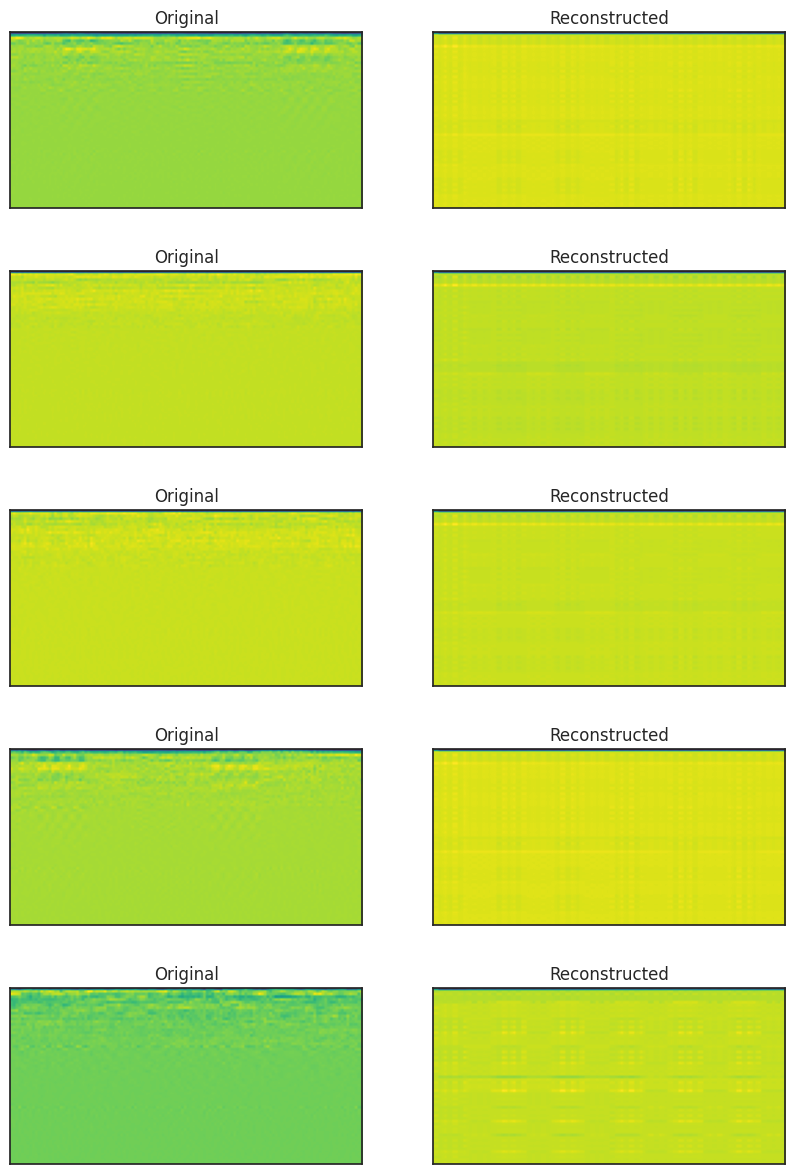

In [21]:
#load the saved model
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
model_loaded.summary()

#plot the original and reconstructed
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)

Since there's less variability in the audio from unlabelled dataset we evaluate the autoencoder reconstruction on the labelled dataset.

Found 400 files belonging to 10 classes.
Using 300 files for training.
Using 100 files for validation.
Model: "AE_Conv_prep_flatten_MFCC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 64, 128, 1)]      0         
                                                                 
 Encoder (Sequential)        (None, 32)                20240     
                                                                 
 Decoder (Sequential)        (None, 64, 128, 1)        36513     
                                                                 
Total params: 56,753
Trainable params: 56,753
Non-trainable params: 0
_________________________________________________________________
1/1 [==============================] - 0s 21ms/step


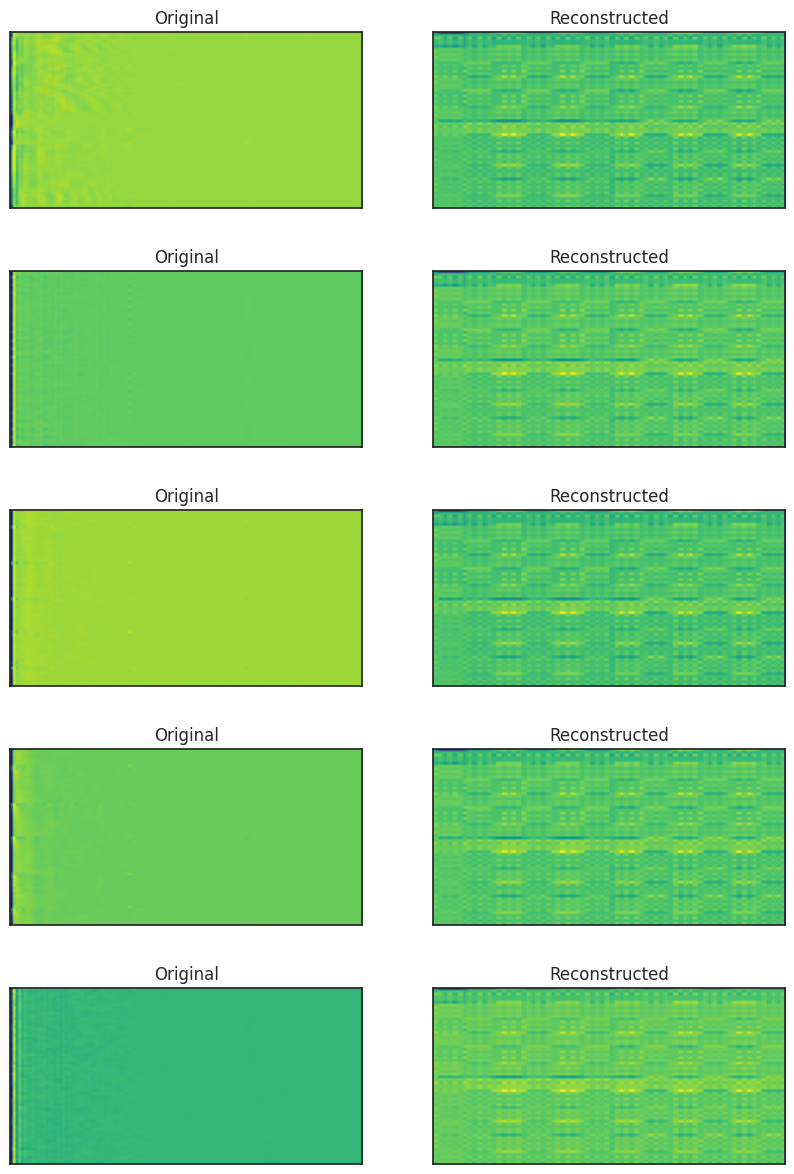

In [22]:
train, val, test, label_names = create_dataset( ESC10_path,
                                                verbose = 0,
                                                batch_size = 30,
                                                validation_split = 0.25, # this is the splitting of train vs validation + test
                                                normalize = True, # normalization preprocessing (default is true)
                                                preprocessing = preprocessing,   # "STFT" or "MFCC"
                                                show_example_batch = False,
                                                ndim=3,
                                                resize = True,
                                                new_width = 64,
                                                new_height= 128)
model_loaded = tf.keras.models.load_model(os.path.join(main_dir,'Saved_Models',AE_name))
model_loaded.summary()
# show n original and reconstructed images
plot_original_reconstructed(model = model_loaded, n_figures = 5, test=test)